# missing data interpolation

statistics is the answer to everything

### potential shenanigans

"Several techniques have been used to fill the gaps in either the UWLS or OI derived total vector maps.

These are implemented using covariance derived from normal mode analysis (Lipphardt et al. 2000), open-boundary modal analysis (OMA) (Kaplan and Lekien 2007), and empirical orthogonal function (EOF) analysis (Beckers and Rixen 2003; Alvera-Azcárate et al. 2005); and using idealized or smoothed observed covariance (Davis 1985)."

- normal mode analysis
- open-boundary modal analysis (OMA)
- empirical orthogonal function analysis (EOF)
- use idealized/smoothed observed covariance

---

### other ideas

DINEOF (could only find an implementation in R)

to be honest I don't understand any of these methods but they look cool

### currently implemented:

rip data straight from the lower resolution data for areas where data is considered missing in the high resolution data

In [38]:
%matplotlib inline

In [39]:
import math
import time
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from parcels import FieldSet
from datetime import timedelta, datetime

In [40]:
DATA_6KM = 6
DATA_2KM = 2
DATA_1KM = 1

filename_dict = {
    DATA_6KM: "west_coast_6km_hourly",
    DATA_2KM: "west_coast_2km_hourly",
    DATA_1KM: "west_coast_1km_hourly"
}

def get_file_info(path, res):
    xrds = xr.open_dataset(path)
    # flat mesh so the velocity data isn't converted when retrieving interpolated velocities
    fs = FieldSet.from_xarray_dataset(
        xrds.copy(deep=True),
        dict(U="u",V="v"),
        dict(lat="lat",lon="lon",time="time"),
        mesh="flat"
    )
    xrds.close()
    lat = xrds["lat"].values
    lon = xrds["lon"].values
    return dict(
        path = path,
        res = res,
        xrds = xrds,
        fs = fs,
        timerng = (xrds["time"].min().values, xrds["time"].max().values),
        lat = lat,
        lon = lon,
        domain = {
            "S": lat.min(),
            "N": lat.max(),
            "W": lon.min(),
            "E": lon.max(),
        }
    )

### target and interp_references

`target` is the data you are interpolating.

`interp_references` is a list of reference data to interpolate from. A few specifications:
- should be ordered from most accurate data to least accurate
- time domain should be identical or bigger than the one of the target
- lat and lon domain should be bigger than the target's to prevent any out-of-bounds complications

In [41]:
target = get_file_info("west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river.nc", DATA_1KM)

interp_references = [
    get_file_info("west_coast_2km_hourly_netcdfs/west_coast_2km_hourly_region0.nc", DATA_2KM),
    get_file_info("west_coast_6km_hourly_netcdfs/west_coast_6km_hourly_region0.nc", DATA_6KM)
]

### interpolation type

more information can be found in the `tutorial_interpolation` notebook

it's mostly finding whether `linear` or `linear_invdist_land_tracer` works better

FUN FACT: parcels lets you change the interp method for U and V fields to `linear_invdist_land_tracer` and even access values from it, but doesn't work when you stick the FieldSet into a ParticleSet.

maybe this means `linear_invdist_land_tracer` shouldn't be used for velocity interpolation?

In [42]:
reference_interp_method = "linear"
# reference_interp_method = "linear_invdist_land_tracer"

for r in interp_references:
    r["fs"].U.interp_method = reference_interp_method
    r["fs"].V.interp_method = reference_interp_method

## nan values and parcels

note that when this xarray Dataset is passed into parcels, all the nan values change to 0 and the mask generation won't work anymore

so the Dataset is copied for use with the FieldSet instead

In [43]:
def generate_mask(data):
    """
    Generates a boolean mask signifying which points in the data are invalid.
    
    Args:
        data (np.ndarray): an array with the shape of (time, lat, lon)
    """
    mask = np.zeros(data.shape, dtype=bool)
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            point = data.T[j][i]
            nan_vals = np.isnan(point)
            # if the point at (lat, lon) contains real data and nan values
            # mark those points as invalid
            if not nan_vals.all():
                mask.T[j][i][:] = np.where(nan_vals.flatten(), 1, 0)
    return mask

In [44]:
invalid = generate_mask(target["xrds"]["u"].values)
num_invalid = invalid.sum()
print(f"total invalid values on target data: {num_invalid}")

total invalid values on target data: 14151


In [45]:
invalid_pos = np.where(invalid)
invalid_pos

(array([  0,   0,   0, ..., 168, 168, 168]),
 array([ 0,  0,  0, ..., 15, 15, 16]),
 array([ 0,  1,  2, ...,  9, 10,  7]))

### use of Parcels Field for interpolation

indexing Field values goes [time, depth, lat, lon]

Field does interpolation automatically when indexing values between it's coordinate values

### note

https://stackoverflow.com/questions/12923586/nearest-neighbor-search-python

in theory, the latitude and longitude values are equally spaced. however, the difference between the coordinate values always flucuates a very small amount between two distinct values, so it's not perfectly equally spaced.

from testing, this causes enough error to completely change a simulation, so a kdtree must be used.

In [70]:
import scipy.spatial

for f in interp_references:
    f["latkdtree"] = scipy.spatial.cKDTree(np.array([f["lat"]]).T)
    f["lonkdtree"] = scipy.spatial.cKDTree(np.array([f["lon"]]).T)

In [71]:
def get_interped(i, ref, vec, invalid_where):
    """
    Args:
        i (int)
        ref (dict)
        vec (str): either u or v
        invalid_where (array-like)
    
    Returns:
        float: nan if no data was found, interpolated value otherwise
    """
    time_diff = np.diff(ref["fs"].U.grid.time)[0]
    t = invalid_where[0][i]
    lat = target["lat"][invalid_where[1][i]]
    lon = target["lon"][invalid_where[2][i]] 
    if np.isnan(ref["xrds"][vec].values[t, ref["latkdtree"].query([lat])[1], ref["lonkdtree"].query([lon])[1]]):
        return np.nan
    if vec == "u":
        return ref["fs"].U[t * time_diff, 0, lat, lon]
    return ref["fs"].V[t * time_diff, 0, lat, lon]

### today i learned

doing DataArray.values does not return a numpy array copy

In [49]:
time_st = time.time()
target_interped_u = target["xrds"]["u"].values.copy()
target_interped_v = target["xrds"]["v"].values.copy()
invalid_interped = invalid.copy()
for f in interp_references:
    invalid_pos_new = np.where(invalid_interped)
    num_invalid_new = invalid_interped.sum()
    target_interped_u[invalid_pos_new] = [get_interped(i, f, "u", invalid_pos_new) for i in range(num_invalid_new)]
    target_interped_v[invalid_pos_new] = [get_interped(i, f, "v", invalid_pos_new) for i in range(num_invalid_new)]
    invalid_interped = generate_mask(target_interped_u)
time_en = time.time()
print(f"time elapsed: {time_en - time_st}")

time elapsed: 10.134448051452637


In [50]:
print(f"total invalid values on interpolated: {invalid_interped.sum()}")

total invalid values on interpolated: 758


### gridfill invalid values after interpolation

in theory there should still be invalid spaces left over because the 6 km data will sometimes have gaps

hopefully after this interpolation, the gaps of invalid data are small enough to let gridfilling finish the job

In [14]:
import numpy.ma as ma
from gridfill import fill

masked_u = ma.masked_array(target_interped_u, invalid_interped)
masked_v = ma.masked_array(target_interped_v, invalid_interped)

kw = dict(eps=1e-4, relax=0.6, itermax=1e4, initzonal=False,
          cyclic=False, verbose=True)

# since data is 3d, use axes 2 and 1 since axis 0 is time
filled_u, converged_u = fill(masked_u, 2, 1, **kw)
filled_v, converged_v = fill(masked_v, 2, 1, **kw)

[0] relaxation converged (1 iterations with maximum residual 0.000e+00)
[1] relaxation converged (0 iterations with maximum residual 0.000e+00)
[2] relaxation converged (1 iterations with maximum residual 0.000e+00)
[3] relaxation converged (1 iterations with maximum residual 0.000e+00)
[4] relaxation converged (2 iterations with maximum residual 0.000e+00)
[5] relaxation converged (2 iterations with maximum residual 0.000e+00)
[6] relaxation converged (1 iterations with maximum residual 0.000e+00)
[7] relaxation converged (1 iterations with maximum residual 0.000e+00)
[8] relaxation converged (1 iterations with maximum residual 0.000e+00)
[9] relaxation converged (1 iterations with maximum residual 0.000e+00)
[10] relaxation converged (2 iterations with maximum residual 0.000e+00)
[11] relaxation converged (2 iterations with maximum residual 0.000e+00)
[12] relaxation converged (2 iterations with maximum residual 0.000e+00)
[13] relaxation converged (2 iterations with maximum residual

In [15]:
invalid_filled = generate_mask(filled_u)
print(f"total invalid values on filled: {invalid_filled.sum()}")

total invalid values on filled: 1189


In [16]:
print(f"percent invalid filled: {(invalid_interped.sum() - invalid_filled.sum()) / invalid_interped.sum()}")

percent invalid filled: 0.0


### wow

unsurprisingly gridfill did jack shit

### formatting, saving, and testing

In [17]:
def conv_to_dataarray(arr, dataarr):
    """
    Args:
        arr (array-like)
        dataarr (xr.DataArray): only used to label coordinates, dimensions, and metadata.
    """
    return xr.DataArray(arr, coords=dataarr.coords, dims=dataarr.dims, attrs=dataarr.attrs)

In [18]:
# re-add coordinates, dimensions, and metadata to interpolated data
darr_u = conv_to_dataarray(filled_u, target["xrds"]["u"])
darr_v = conv_to_dataarray(filled_v, target["xrds"]["v"])
target_interped_xrds = target["xrds"].drop_vars(["u", "v"]).assign(u=darr_u, v=darr_v)
target_interped_xrds

<xarray.Dataset>
Dimensions:                (lat: 20, lon: 17, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.53346 32.54245 ... 32.69528 32.70427
  * lon                    (lon) float32 -117.28391 -117.2735 ... -117.11733
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
    u                      (time, lat, lon) float64 0.05 0.065 0.08 ... nan nan
    v                      (time, lat, lon) float64 -0.17 -0.185 ... nan nan
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007060600siohfruwlsrtvuswc1km
    date_created:              2020-07-06T07:48:41Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-06T07:19:24Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_1km_Resolutio...

In [19]:
save_path = target["path"].split(".nc")[0] + "_interped.nc"
target_interped_xrds.to_netcdf(save_path)
print(f"saved to {save_path}")

saved to west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_interped.nc


### display field to see if interpolation worked

In [20]:
fs_interp = FieldSet.from_xarray_dataset(target_interped_xrds.copy(deep=True), dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))

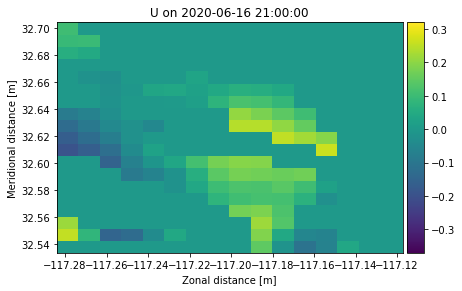

/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


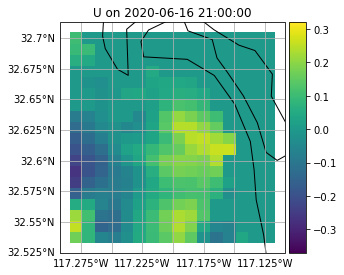

In [21]:
target["fs"].U.show()
fs_interp.U.show()